# Setting Up

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input, decode_predictions
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import os
import matplotlib.pyplot as plt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: 

In [ ]:
# Set up directory paths
base_dir = '/content/drive/MyDrive/AI/Skin Cancer/Skin Cancer'
img_path = '/content/drive/MyDrive/AI/Skin Cancer/Skin Cancer/combined_images'
metadata_file = '/content/drive/MyDrive/AI/HAM10000_metadata.csv'
labels_csv='/content/drive/MyDrive/AI/final_labels_df.csv'

labels_df = pd.read_csv(labels_csv)
image_paths = labels_df['image_id'].values
string_labels = labels_df['dx'].values

# Combine the directory path with the filenames
image_paths = [os.path.join(img_path, filename) for filename in image_paths]

# Map string labels to integers
label_mapping = {'not melanoma': 0, 'melanoma': 1}
numeric_labels = np.array([label_mapping[label] for label in string_labels])

# Encode labels to one-hot vectors
labels = to_categorical(numeric_labels, num_classes=2)

# Split data into training and testing sets
train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

# Parameters
img_height, img_width = 224, 224
batch_size = 32

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
# Function to load and preprocess images
def load_and_preprocess_image(img_path):
    if not os.path.exists(img_path):
        print(f"File not found: {img_path}")
    img = load_img(img_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    return img


In [ ]:
def generator(image_paths, labels, batch_size):
    while True:
        for start in range(0, len(image_paths), batch_size):
            end = min(start + batch_size, len(image_paths))
            batch_paths = image_paths[start:end]
            batch_labels = labels[start:end]
            batch_images = np.array([load_and_preprocess_image(img_path) for img_path in batch_paths])
            yield batch_images, batch_labels

# Train

In [ ]:
train_generator = generator(train_paths, train_labels, batch_size)
test_generator = generator(test_paths, test_labels, batch_size)

In [ ]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

In [ ]:
# Freeze the layers except the last 4 layers
for layer in base_model.layers[:-4]:
    layer.trainable = False

In [ ]:
# Add custom top layers
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

In [ ]:
# Create and compile the final model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
steps_per_epoch = len(train_paths) // batch_size
validation_steps = len(test_paths) // batch_size

In [ ]:
model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=4,
    validation_data=test_generator,
    validation_steps=validation_steps,
    #callbacks=[early_stopping]
)
# Save the entire model to a file
model.save('/content/drive/MyDrive/AI/efficientnet_melanoma_classifier2.keras')

Epoch 1/4
445/445 ━━━━━━━━━━━━━━━━━━━━ 4712s 11s/step - accuracy: 0.8466 - loss: 0.5378 - val_accuracy: 0.9231 - val_loss: 0.2144
Epoch 2/4
445/445 ━━━━━━━━━━━━━━━━━━━━ 2029s 5s/step - accuracy: 0.9093 - loss: 0.2515 - val_accuracy: 0.9272 - val_loss: 0.2173
Epoch 3/4
445/445 ━━━━━━━━━━━━━━━━━━━━ 2062s 5s/step - accuracy: 0.9271 - loss: 0.1983 - val_accuracy: 0.9343 - val_loss: 0.1771
Epoch 4/4
445/445 ━━━━━━━━━━━━━━━━━━━━ 2141s 5s/step - accuracy: 0.9402 - loss: 0.1525 - val_accuracy: 0.9371 - val_loss: 0.1620


In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator, steps=validation_steps)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

111/111 ━━━━━━━━━━━━━━━━━━━━ 357s 3s/step - accuracy: 0.9404 - loss: 0.1521
Test Loss: 0.16496431827545166
Test Accuracy: 0.9362425804138184


# Testing the model with the testing/sample data

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/AI/efficientnet_melanoma_classifier2.keras')

In [ ]:
img_paths = ["ISIC_0024951", "ISIC_0030106", "ISIC_0031779", "ISIC_0028442", "ISIC_0031745", "ISIC_0031586", "ISIC_0031972", "ISIC_0030539"]
img_paths2 = ["ISIC_0027326", "ISIC_0030789", "ISIC_0027008", "ISIC_0028790", "ISIC_0028880", "ISIC_0025009", "ISIC_0033492", "ISIC_0030021"]
for i in range(len(img_paths)):
  img_paths[i] = "/content/drive/MyDrive/AI/Skin Cancer/Skin Cancer/" + img_paths[i] + ".jpg"
  img_paths2[i] = "/content/drive/MyDrive/AI/Skin Cancer/Skin Cancer/" + img_paths2[i] + ".jpg"

classification = {v: k for k, v in label_mapping.items()}

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Predict
print("Melanoma images:")
for i in img_paths:
  # Preprocess the image
  preprocessed_image = preprocess_image(i)
  pred = model.predict(preprocessed_image)
  print(pred, classification[np.argmax(pred, axis=-1)[0]])

print("\nNon-Melanoma images:")
for i in img_paths2:
  # Preprocess the image
  preprocessed_image = preprocess_image(i)
  pred = model.predict(preprocessed_image)
  print(pred, classification[np.argmax(pred, axis=-1)[0]])

# Plotting

In [ ]:
# Manually extracted values
epochs = list(range(1, 5))

# Accuracy values (old ones commented out)
accuracy = [0.8466, 0.9093, 0.9271, 0.9402] #[0.8959, 0.9225, 0.9363, 0.9460, 0.9556, 0.9643, 0.9664, 0.9759, 0.9773, 0.9806]
val_accuracy = [0.9231, 0.9272, 0.9343, 0.9371] #[0.9358, 0.9378, 0.9408, 0.9439, 0.9447, 0.9473, 0.9453, 0.9462, 0.9450, 0.9484]

# Loss values
loss = [0.5378, 0.2515, 0.1983,0.1525] #[0.3608, 0.2373, 0.1740, 0.1453, 0.1177, 0.0943, 0.0859, 0.0676, 0.0622, 0.0502]
val_loss = [0.2144, 0.2173, 0.1771,0.162] #[0.1818, 0.1627, 0.1540, 0.1555, 0.1570, 0.1709, 0.1870, 0.1977, 0.1727, 0.1659]

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
batch_size = 32
num_test_samples = 3561
steps_per_epoch = num_test_samples / batch_size
predictions = model.predict(test_generator, steps=112)

112/112 ━━━━━━━━━━━━━━━━━━━━ 1832s 16s/step


In [ ]:
# Convert probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)
convert = lambda x : 0 if x[1] == 1. else 1
test_labelsconf = list(map(convert, test_labels))

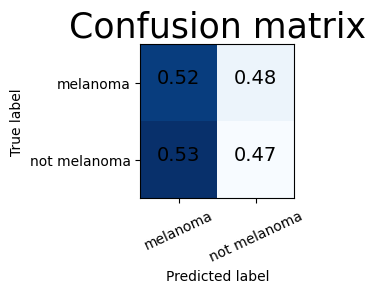

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(actual, predicted):

    cm = confusion_matrix(actual, predicted)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(2,2))
    cmap=plt.cm.Blues
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix', fontsize=25)

    tick_marks = np.arange(2)
    classes = ['melanoma', 'not melanoma']
    plt.xticks(tick_marks, classes, rotation=25)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'),
        horizontalalignment="center",
        color="black", fontsize = 14)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
# Convert to a NumPy array
plot_confusion_matrix(test_labelsconf, predicted_classes)

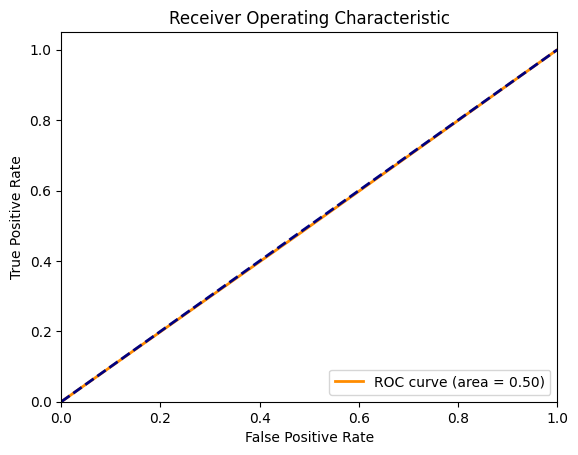

In [ ]:
# Calculate ROC Curve and AUC
from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr, tpr, _ = roc_curve(test_labelsconf, predicted_classes)
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
